In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch

from torch import nn
torch.cuda.empty_cache()

import sys
sys.path.append('../')
from model_runner import ModelRunner
from image_helper import ImageHelper 
from SRCNN_different_specs import SRCNN
from SRCNN import SRCNN
from custom_image_dataset import CustomImageDataset

sys.path.append('../DBPN/')
from DBPN_copied import DBPN

sys.path.append('../SRGAN/')
from srgan import Generator


In [2]:
DATASET_ROOT="../datasets/"
DATASET_NAME = "BSDS100"
# DATASET_NAME = "set14"
# DATASET_NAME = "Set5"
FULL_DATASET_PATH = f"{DATASET_ROOT}{DATASET_NAME}"
model_runner = ModelRunner()
image_helper = ImageHelper()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

UPSCALE_FACTOR = 4

# Load models
srcnn = SRCNN(f2=5).to(device)
dbpn = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=UPSCALE_FACTOR).to(device)
srgan = Generator(UPSCALE_FACTOR).to('cpu')

srgan.load_state_dict(torch.load('../results/srgan/trained_models/srgan_netG_follwing_paper_118_epochs_graphs_are_working.pth',  map_location=torch.device('cpu')))
# srgan.load_state_dict(torch.load('../results/srgan/trained_models/srgan_netG-150-epochs.pth',  map_location=torch.device('cpu')))
srcnn.load_state_dict(torch.load('./srcnn/trained_models/model_f2_5.pth', map_location=torch.device('cpu')))
dbpn.load_state_dict(torch.load('./dbpn/trained_models/model-05-08-epoch=0-299.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
model_runner.compare_models([
                              {"name": "SRCNN", "model": srcnn, "scale": 4},
                              
                              {"name": "DBPN", "model": dbpn,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
                                
                               {"name": "SRGAN", "model": srgan,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },

                              ], FULL_DATASET_PATH, scale=4)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
SRCNN,23.475832,0.630277
DBPN,24.842781,0.653355
SRGAN,24.135324,0.664656
Bicubic,23.045410,0.632868


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

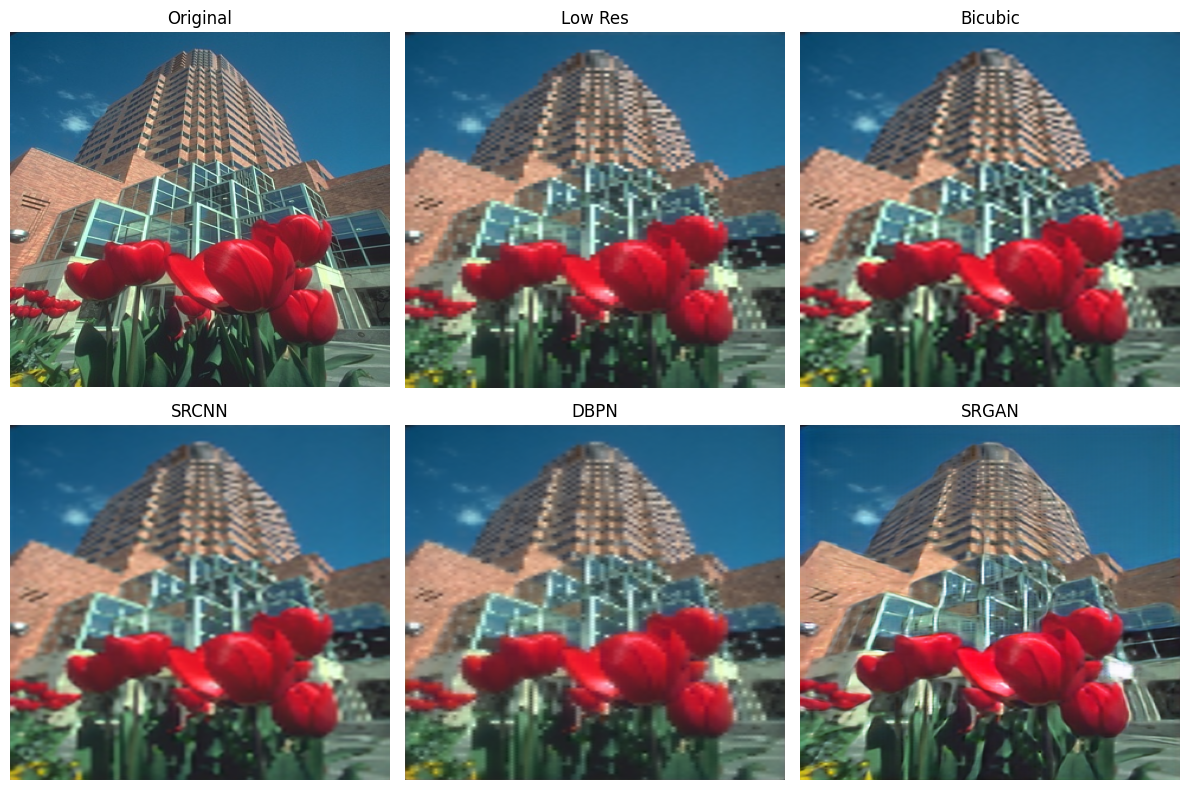

In [5]:
IMAGE_EXAMPLE = "../datasets/BSDS100/86000.png"

image_helper.show_tensors_custom_grid(
    tensors = [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        {
            "label": "SRCNN",
            "tensor": image_helper.apply_model_to_image(
                srcnn,
                IMAGE_EXAMPLE,
                4
            )
        },
        

        {
            "label": "DBPN",
            "tensor": image_helper.apply_model_to_image(
                model=dbpn,
                image=IMAGE_EXAMPLE,
                downsample_factor=4,
                should_upsample=False,
                unsqueeze=True
            )
        },
        {
            "label": "SRGAN",
            "tensor": image_helper.apply_model_to_image(
                srgan.to('cpu'),
                IMAGE_EXAMPLE,
                downsample_factor=4,
                should_upsample=False,
                unsqueeze=True,
                device='cpu'
            )
        },
    ],
    rows=2,
    cols=3
)